<a href="https://colab.research.google.com/github/aurna31/AttractingContributors-shows-or-series/blob/main/FedFusion_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# new attempt

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Attention
#from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
data1 = pd.read_csv("/kaggle/input/cc-3datasets-for-journal/CC_Dataset01.csv")
data2 = pd.read_csv("/kaggle/input/cc-3datasets-for-journal/CC_Dataset02new.csv")
data3 = pd.read_csv("/kaggle/input/cc-3datasets-for-journal/CC_Dataset03.csv")

In [ ]:
label_counts2 = y_train_client3.value_counts()

# Print the counts
print("Non-Fraud Count:", label_counts2[0])
print("Fraud Count:", label_counts2[1])

# Outlier removal

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats

# Assuming 'data' is your DataFrame with features and labels (0 for majority, 1 for minority)

# Separate majority and minority classes
majority_class1 = data1[data1['Class'] == 0]
minority_class1 = data1[data1['Class'] == 1]
majority_class2 = data2[data2['fraud'] == 0]
minority_class2 = data2[data2['fraud'] == 1]
majority_class3 = data3[data3['y'] == 0]
minority_class3 = data3[data3['y'] == 1]

def remove_outliers_limit_percentage(dataframe, features, threshold=3, max_percentage=1):
    z_scores = np.abs(stats.zscore(dataframe[features]))
    outliers_mask = (z_scores < threshold).all(axis=1)

    # Calculate the percentage of outliers in the majority class
    outliers_percentage = outliers_mask.sum() / len(dataframe)

    # If the percentage exceeds the limit, keep only a subset
    if outliers_percentage > max_percentage:
        # Sort the outliers by their Z-scores and keep only the top (max_percentage) percent
        sorted_outliers_indices = np.argsort(np.max(z_scores, axis=1))
        keep_samples = int((1 - max_percentage) * len(dataframe))
        outliers_mask = np.zeros_like(outliers_mask)
        outliers_mask[sorted_outliers_indices[:keep_samples]] = True

    return dataframe[outliers_mask]

In [ ]:
# Specify the features for outlier removal
features_for_outlier_removal1 = ['V4', 'V14', 'V9']

# Remove outliers from the majority class, limiting to 1% of the majority class
majority_class_no_outliers1 = remove_outliers_limit_percentage(majority_class1.reset_index(drop=True), features_for_outlier_removal1, max_percentage=0.1)
#minority_class_no_outliers = remove_outliers_limit_percentage(minority_class.reset_index(drop=True), features_for_outlier_removal, max_percentage=0.01)

# Concatenate the majority class without outliers with the minority class
data_no_outliers1 = pd.concat([majority_class_no_outliers1, minority_class1])

# Shuffle the DataFrame to mix classes
data_no_outliers1 = data_no_outliers1.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# Specify the features for outlier removal
features_for_outlier_removal2 = ['ratio_to_median_purchase_price', 'online_order', 'distance_from_home']

# Remove outliers from the majority class, limiting to 1% of the majority class
majority_class_no_outliers2 = remove_outliers_limit_percentage(majority_class2.reset_index(drop=True), features_for_outlier_removal2, max_percentage=0.01)
#minority_class_no_outliers = remove_outliers_limit_percentage(minority_class.reset_index(drop=True), features_for_outlier_removal, max_percentage=0.01)

# Concatenate the majority class without outliers with the minority class
data_no_outliers2 = pd.concat([majority_class_no_outliers2, minority_class2])

# Shuffle the DataFrame to mix classes
data_no_outliers2 = data_no_outliers2.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# Specify the features for outlier removal
features_for_outlier_removal3 = ['e0', 'e3', 'e4']

# Remove outliers from the majority class, limiting to 1% of the majority class
majority_class_no_outliers3 = remove_outliers_limit_percentage(majority_class3.reset_index(drop=True), features_for_outlier_removal3, max_percentage=0.01)
#minority_class_no_outliers = remove_outliers_limit_percentage(minority_class.reset_index(drop=True), features_for_outlier_removal, max_percentage=0.01)

# Concatenate the majority class without outliers with the minority class
data_no_outliers3 = pd.concat([majority_class_no_outliers3, minority_class3])

# Shuffle the DataFrame to mix classes
data_no_outliers3 = data_no_outliers3.sample(frac=1, random_state=42).reset_index(drop=True)

# Preprocess data

In [ ]:
def preprocess_csv_dataset(df, target, max_features,us,os, test_size=0.2, random_state=42):
    # Load the dataset from CSV file


    # Extract the features and labels
    X = df.drop(target, axis=1)
    y = df[target]


    # Define the undersampling ratio (fraud class will be 10% of the normal class)
    undersample_ratio = us

    # Instantiate the RandomUnderSampler
    undersampler = RandomUnderSampler(sampling_strategy=undersample_ratio, random_state=42)

    # Fit and apply the undersampler to the training data
    X_resampled, y_resampled = undersampler.fit_resample(X, y)

    smote = SMOTE(sampling_strategy=os, random_state=42)

    # Fit and apply SMOTE to the undersampled data
    X_resampled, y_resampled = smote.fit_resample(X_resampled, y_resampled)

    # Split the preprocessed data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=test_size, stratify=y_resampled,
                                                      random_state=random_state)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.fit_transform(X_val)

    #X_train = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
    #X_val = X_val_scaled.reshape((X_val_scaled.shape[0], X_val_scaled.shape[1], 1))

    return X_train_scaled, X_val_scaled, y_train, y_val


In [ ]:
X_train_client1, X_val_client1, y_train_client1, y_val_client1 = preprocess_csv_dataset(data1, 'Class', 26,0.002,0.1, test_size=0.2, random_state=42)
#X_train_client4, X_val_client4, y_train_client4, y_val_client4 = preprocess_csv_dataset('/kaggle/input/ealtman-cc-fraud15-features/ealtman_new.csv', 'Is Fraud?', 18, test_size=0.2, random_state=42)

In [ ]:
X_train_client2, X_val_client2, y_train_client2, y_val_client2 = preprocess_csv_dataset(data2, 'fraud',  26,0.0999,0.1, test_size=0.2, random_state=42)

In [ ]:
X_train_client3, X_val_client3, y_train_client3, y_val_client3 = preprocess_csv_dataset(data3,'y', 26,0.002,0.1, test_size=0.2, random_state=42)

In [ ]:
X_train_client1.shape

(243540, 26)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
# Calculate class weights to handle imbalance
#class_weights = compute_class_weight('balanced', classes=np.unique(ytrain), y=ytrain)

# Convert class weights to a dictionary format
#class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
class_weight_dict = {0: 1.0, 1: 10.0}

# Define your custom loss function with class weights
def custom_weighted_loss(y_true, y_pred):
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.keras.backend.clip(y_pred, epsilon, 1 - epsilon)

    # Convert y_true to float32 to match y_pred
    y_true = tf.cast(y_true, tf.float32)

    weighted_losses = -(class_weight_dict[1] * y_true * tf.keras.backend.log(y_pred) +         #0-1--> improve majority, 1-0-->improve minority
                        class_weight_dict[0] * (1 - y_true) * tf.keras.backend.log(1 - y_pred))
    return tf.keras.backend.mean(weighted_losses)

In [ ]:
# Define the MLP model
model = keras.Sequential()
model.add(keras.layers.Dense(128, activation='relu', input_shape=(26, )))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss=custom_weighted_loss, metrics=['accuracy'])

In [ ]:
# Define the MLP model with attention
model = keras.Sequential()

# Add Dense layers with LeakyReLU activation
model.add(Dense(256, activation=keras.layers.LeakyReLU(alpha=0.2), input_shape=(26, )))
#model.add(Dense(256, activation=keras.layers.LeakyReLU(alpha=0.2)))
model.add(Dense(128, activation=keras.layers.LeakyReLU(alpha=0.2)))
model.add(Dense(64, activation=keras.layers.LeakyReLU(alpha=0.2)))
model.add(keras.layers.Dense(32, activation='relu'))

# Explicitly create a query tensor (Q) and pass it to the Attention layer
query = Dense(32)(model.layers[-1].output)  # Adjust the size as needed
attention = Attention()([query, model.layers[-1].output])


# Add the output layer
model.add(Dense(1, activation='sigmoid'))
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
#class_weights = compute_class_weight('balanced', classes=np.unique(ytrain2), y=ytrain2)
# Convert class weights to a dictionary format
#class_weight_dictt = dict(zip(np.unique(ytrain2), class_weights))
class_weight_dict_modified1 = {0: 1.0, 1: 5.0}
class_weight_dict_modified2 = {0: 1.0, 1: 7.0}
class_weight_dict_modified3 = {0: 1.0, 1: 12.0}

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
#checkpoint = ModelCheckpoint("MLP_D2V2_personalized_NewData.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.1, patience = 2, min_delta = 0.01,
                              mode='auto',verbose=1)

In [ ]:
custom_weighted_loss

<function __main__.custom_weighted_loss(y_true, y_pred)>

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
#reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.1, patience = 2,
                              #mode='auto',verbose=1)

In [ ]:
from tensorflow.keras.models import load_model
# Define the number of communication rounds
communication_rounds = 101

# Create the global model
global_model = model  # Adjust input shape based on the maximum feature dimensions

# Create the local models for each client
# Load the model
local_model_client1 = load_model("/kaggle/input/cc-3-modelsmlp-journal/MLP_D1_personalized_NewData.h5") # Adjust input shape based on the maximum feature dimensions of dataset 1
local_model_client2 = load_model("/kaggle/input/cc-3-modelsmlp-journal/MLP_D2V2_personalized_NewData.h5")  # Adjust input shape based on the maximum feature dimensions of dataset 2
local_model_client3 = load_model("/kaggle/input/cc-3-modelsmlp-journal/MLP_D3_personalized_NewData.h5")
#local_model_client4 = model

In [ ]:
local_model_client1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
local_model_client2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
local_model_client3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training local models

In [ ]:
# Initialize a dictionary to track previous and current accuracies
accuracy_dict = {1: None, 2: None, 3: None, 4: None}

# Define the previous_accuracy function to retrieve the previous accuracy
def previous_accuracy(client_num):
    return accuracy_dict[client_num]

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
def calculate_accuracy(X_val, y_val, model):
    y_pred = model.predict(X_val) # Round predicted probabilities to obtain binary labels (0 or 1)
    y_pred = (y_pred > 0.5).astype(int)
    #accuracy = np.mean(y_pred == y_val)
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy

In [ ]:
local_models=[local_model_client1, local_model_client2, local_model_client3]

# normal fedAvg

In [ ]:
train_accuracies_client1 = []
train_accuracies_client2 = []
train_accuracies_client3 = []
# Start the federated learning loop

for round_num in range(communication_rounds):
    print(f"Communication Round {round_num + 1}/{communication_rounds}")
    # Train the local models on their respective datasets
    local_model_client1.fit(X_train_client1, y_train_client1, validation_split=0.1, epochs =1, verbose=1, batch_size=32,
                    )
    local_model_client2.fit(X_train_client2, y_train_client2, validation_split=0.1, epochs =1, verbose=1, batch_size=32,
                    )
    local_model_client3.fit(X_train_client3, y_train_client3, validation_split=0.1, epochs =1, verbose=1, batch_size=32,
                    )

    # Calculate and store the current training accuracy for each client
    train_accuracies_client1.append(local_model_client1.evaluate(X_train_client1, y_train_client1, verbose=0)[1])
    train_accuracies_client2.append(local_model_client2.evaluate(X_train_client2, y_train_client2, verbose=0)[1])
    train_accuracies_client3.append(local_model_client3.evaluate(X_train_client3, y_train_client3, verbose=0)[1])

    # Calculate the fraction of data for each client
    total_data = len(X_train_client1) + len(X_train_client2) + len(X_train_client3)
    fraction_client1 = len(X_train_client1) / total_data
    fraction_client2 = len(X_train_client2) / total_data
    fraction_client3 = len(X_train_client3) / total_data

    # Perform weighted federated averaging
    num_clients = 3
    global_model_weights = global_model.get_weights()

    for i in range(len(global_model_weights)):
        global_model_weights[i] = (fraction_client1 * local_model_client1.get_weights()[i] +
                               fraction_client2 * local_model_client2.get_weights()[i] +
                               fraction_client3 * local_model_client3.get_weights()[i]) / num_clients
    # Set the updated weights to the global model
    global_model.set_weights(global_model_weights)

    # Get the weights of the global model
    global_weights = global_model.get_weights()

    # Assign the global weights to the local models

    local_model_client1.set_weights(global_weights)
    local_model_client2.set_weights(global_weights)
    local_model_client3.set_weights(global_weights)
    #Calculate the current accuracy for each client
    #current_accuracy = {
        #1: calculate_accuracy(X_val_client1, y_val_client1, local_model_client1),
        #2: calculate_accuracy(X_val_client2, y_val_client2, local_model_client2),
        #3: calculate_accuracy(X_val_client3, y_val_client3, local_model_client2)
    #}
    # Iterate over each client and assign weights conditionally
    #for client_num, client_accuracy in current_accuracy.items():
        #local_models[client_num - 1].set_weights(global_weights)


# Normal alpha

In [ ]:
train_accuracies_client1 = []
train_accuracies_client2 = []
train_accuracies_client3 = []
# Start the federated learning loop

for round_num in range(communication_rounds):
    print(f"Communication Round {round_num + 1}/{communication_rounds}--------")
    # Train the local models on their respective datasets
    print('c1:')
    local_model_client1.fit(X_train_client1, y_train_client1, validation_split=0.1,class_weight=class_weight_dict_modified1, epochs =1, verbose=1, batch_size=32,
                    )
    print('c2:')
    local_model_client2.fit(X_train_client2, y_train_client2, validation_split=0.1,class_weight=class_weight_dict_modified2, epochs =1, verbose=1, batch_size=32,
                    )
    print('c3:')
    local_model_client3.fit(X_train_client3, y_train_client3, validation_split=0.1,class_weight=class_weight_dict_modified3, epochs =3, verbose=1, batch_size=32,
                    )

    # Calculate and store the current training accuracy for each client
    train_accuracies_client1.append(local_model_client1.evaluate(X_train_client1, y_train_client1, verbose=0)[1])
    train_accuracies_client2.append(local_model_client2.evaluate(X_train_client2, y_train_client2, verbose=0)[1])
    train_accuracies_client3.append(local_model_client3.evaluate(X_train_client3, y_train_client3, verbose=0)[1])

    # Calculate the fraction of data for each client
    total_data = len(X_train_client1) + len(X_train_client2) + len(X_train_client3)
    fraction_client1 = len(X_train_client1) / total_data
    fraction_client2 = len(X_train_client2) / total_data
    fraction_client3 = len(X_train_client3) / total_data

    # Perform weighted federated averaging
    num_clients = 3
    global_model_weights = global_model.get_weights()

    for i in range(len(global_model_weights)):
        global_model_weights[i] = (fraction_client1 * local_model_client1.get_weights()[i] +
                                   fraction_client2 * local_model_client2.get_weights()[i] +
                                   fraction_client3 * local_model_client3.get_weights()[i]) / num_clients

    # Set the updated weights to the global model
    global_model.set_weights(global_model_weights)

    # Get the weights of the global model
    global_weights = global_model.get_weights()

    # Assign the weighted global weights to the local models
    local_model_client1_weights = [(1 - 0.5) * local_weight + 0.5 * global_weight
                                   for local_weight, global_weight in zip(local_models[0].get_weights(),
                                                                                 global_weights,
                                                                                 )]
    local_model_client1.set_weights(local_model_client1_weights)

    local_model_client2_weights = [(1 - 0.4) * local_weight + 0.4 * global_weight
                                   for local_weight, global_weight in zip(local_models[1].get_weights(),
                                                                                 global_weights,
                                                                                 )]
    local_model_client2.set_weights(local_model_client2_weights)

    local_model_client3_weights = [(1 - 0.0) * local_weight + 0.0 * global_weight
                                   for local_weight, global_weight in zip(local_models[2].get_weights(),
                                                                                 global_weights,
                                                                                 )]
    local_model_client3.set_weights(local_model_client3_weights)


Communication Round 1/5--------
c1:
6089/6089 [==============================] - 14s 2ms/step - loss: 0.0580 - accuracy: 0.9912 - val_loss: 0.0173 - val_accuracy: 0.9939
c2:
21654/21654 [==============================] - 50s 2ms/step - loss: 1.8751 - accuracy: 0.9698 - val_loss: 0.0348 - val_accuracy: 0.9891
c3:
Epoch 1/3
3812/3812 [==============================] - 9s 2ms/step - loss: 0.1125 - accuracy: 0.9773 - val_loss: 0.0590 - val_accuracy: 0.9794
Epoch 2/3
3812/3812 [==============================] - 8s 2ms/step - loss: 0.0970 - accuracy: 0.9785 - val_loss: 0.0587 - val_accuracy: 0.9794
Epoch 3/3
3812/3812 [==============================] - 8s 2ms/step - loss: 0.0923 - accuracy: 0.9787 - val_loss: 0.0544 - val_accuracy: 0.9813
Communication Round 2/5--------
c1:
6089/6089 [==============================] - 14s 2ms/step - loss: 0.0371 - accuracy: 0.9929 - val_loss: 0.0143 - val_accuracy: 0.9957
c2:
21654/21654 [==============================] - 48s 2ms/step - loss: 0.0873 - accura

# Adjustable alpha (run here)

# New new alpha adjusted

In [ ]:
train_accuracies_client1 = []
train_accuracies_client2 = []
train_accuracies_client3 = []

train_losses_client1 = []
train_losses_client2 = []
train_losses_client3 = []
# Initialize weights for local and global models
local_model_weight1 = 0.5
local_model_weight2 = 0.5
local_model_weight3 = 0.5

best_local_model_client1 = None
best_local_model_client2 = None
best_local_model_client3 = None

best_accuracy_client1 = 0.0
best_accuracy_client2 = 0.0
best_accuracy_client3 = 0.0

best_loss_client1 = float('inf')
best_loss_client2 = float('inf')
best_loss_client3 = float('inf')

# Start the federated learning loop
for round_num in range(communication_rounds):
    print(f"Communication Round {round_num + 1}/{communication_rounds}--------")

    # Train the local models on their respective datasets
    #local_model_client1.fit(X_train_client1, y_train_client1, validation_split=0.1, class_weight=class_weight_dict_modified1, epochs=1, verbose=1, batch_size=32)
    #local_model_client2.fit(X_train_client2, y_train_client2, validation_split=0.1, class_weight=class_weight_dict_modified2, epochs=1, verbose=1, batch_size=32)
    #local_model_client3.fit(X_train_client3, y_train_client3, validation_split=0.1, class_weight=class_weight_dict_modified3, epochs=3, verbose=1, batch_size=32)

    local_model_client1.fit(X_train_client1, y_train_client1, validation_split=0.1, epochs=1, verbose=1, batch_size=32)
    local_model_client2.fit(X_train_client2, y_train_client2, validation_split=0.1, epochs=1, verbose=1, batch_size=32)
    local_model_client3.fit(X_train_client3, y_train_client3, validation_split=0.1, epochs=3, verbose=1, batch_size=32)


    if ((round_num+1) < communication_rounds):

        train_accuracy_client1 = local_model_client1.evaluate(X_train_client1, y_train_client1, verbose=0)[1]
        train_accuracy_client2 = local_model_client2.evaluate(X_train_client2, y_train_client2, verbose=0)[1]
        train_accuracy_client3 = local_model_client3.evaluate(X_train_client3, y_train_client3, verbose=0)[1]

        train_loss_client1 = local_model_client1.evaluate(X_train_client1, y_train_client1, verbose=0)[0]
        train_loss_client2 = local_model_client2.evaluate(X_train_client2, y_train_client2, verbose=0)[0]
        train_loss_client3 = local_model_client3.evaluate(X_train_client3, y_train_client3, verbose=0)[0]
        # Calculate and store the current training accuracy and loss for each client

        # Check if the performance of each client has degraded or improved from the previous round

        # Update best weights and performance for each client if a new best performance is achieved
        if ((train_accuracy_client1 > best_accuracy_client1) and (train_loss_client1 < best_loss_client1)):
            best_local_model_client1 = local_model_client1
            best_accuracy_client1 = train_accuracy_client1
            best_loss_client1 = train_loss_client1
            print('Client 1 best weight updated')

        if ((train_accuracy_client2 > best_accuracy_client2) and (train_loss_client2 < best_loss_client2)):
            best_local_model_client2 = local_model_client2
            best_accuracy_client2 = train_accuracy_client2
            best_loss_client2 = train_loss_client2
            print('Client 2 best weight updated')

        if ((train_accuracy_client3 > best_accuracy_client3) and (train_loss_client3 < best_loss_client3)):
            best_local_model_client3 = local_model_client3
            best_accuracy_client3 = train_accuracy_client3
            best_loss_client3 = train_loss_client3
            print('Client 3 best weight updated')

        if round_num > 0:
            print('recahed here 1....')
            if ((train_accuracy_client1 < train_accuracies_client1[-1]) or (train_loss_client1 > train_losses_client1[-1])):
                local_model_weight1 = min(local_model_weight1 + 0.1, 1.0)
                #global_model_weight1= max(global_model_weight1 - 0.1, 0.0)
                print(f'local model weight for client 1: {local_model_weight1}')
                print('recahed here 2....')


            if ((train_accuracy_client2 < train_accuracies_client2[-1]) or (train_loss_client2 > train_losses_client2[-1])):
                local_model_weight2 = min(local_model_weight2 + 0.1, 1.0)
                #global_model_weight2 = max(global_model_weight2 - 0.1, 0.0)
                print(f'local model weight for client 2: {local_model_weight2}')
                print('recahed here 2....')

            if ((train_accuracy_client3 < train_accuracies_client3[-1]) or (train_loss_client3 > train_losses_client3[-1])):
                local_model_weight3 = min(local_model_weight3 + 0.2, 1.0)
                #global_model_weight3 = max(global_model_weight3 - 0.1, 0.0)
                print(f'local model weight for client 3: {local_model_weight3}')
                print('recahed here 3....')

        # Print modifications made based on performance comparison
        if round_num > 0:
            print('recahed here 4....')
            for client_num, (train_accuracy, train_loss, train_accuracies, train_losses) in enumerate(zip([train_accuracy_client1, train_accuracy_client2, train_accuracy_client3],
                                                                                                        [train_loss_client1, train_loss_client2, train_loss_client3],
                                                                                                        [train_accuracies_client1, train_accuracies_client2, train_accuracies_client3],
                                                                                                        [train_losses_client1, train_losses_client2, train_losses_client3])):
                client_name = f"Client {client_num + 1}"
                if (train_accuracy < train_accuracies[-1] or train_loss > train_losses[-1]):
                    print('recahed final....')
                    print(f"{client_name} performance degraded. Increasing local model weight and decreasing global model weight.")


        # Calculate the fraction of data for each client
        train_accuracies_client1.append(train_accuracy_client1)
        train_accuracies_client2.append(train_accuracy_client2)
        train_accuracies_client3.append(train_accuracy_client3)

        train_losses_client1.append(train_loss_client1)
        train_losses_client2.append(train_loss_client2)
        train_losses_client3.append(train_loss_client3)
        #total_data = len(X_train_client1) + len(X_train_client2) + len(X_train_client3)
        #fraction_client1 = len(X_train_client1) / total_data
        #fraction_client2 = len(X_train_client2) / total_data
        #fraction_client3 = len(X_train_client3) / total_data

        # Perform weighted federated averaging
        num_clients = 3
        global_model_weights = global_model.get_weights()

        for i in range(len(global_model_weights)):
            global_model_weights[i] = (0.3*best_local_model_client1.get_weights()[i] +
                                       0.3*best_local_model_client2.get_weights()[i] +
                                       0.4*best_local_model_client3.get_weights()[i]) / num_clients

        # Set the updated weights to the global model
        global_model.set_weights(global_model_weights)

        # Get the weights of the global model
        global_weights = global_model.get_weights()

        # Update the weights of local models
        local_model_client1.set_weights([local_model_weight1 * local_weight + (1 - local_model_weight1) * global_weight
                                         for local_weight, global_weight in zip(local_models[0].get_weights(), global_weights)])
        local_model_client2.set_weights([local_model_weight2 * local_weight + (1 - local_model_weight2) * global_weight
                                         for local_weight, global_weight in zip(local_models[1].get_weights(), global_weights)])
        local_model_client3.set_weights([local_model_weight3 * local_weight + (1 - local_model_weight3) * global_weight
                                         for local_weight, global_weight in zip(local_models[2].get_weights(), global_weights)])




Communication Round 1/101--------
21654/21654 [==============================] - 71s 3ms/step - loss: 1.4227 - accuracy: 0.9688 - val_loss: 0.0359 - val_accuracy: 0.9904
Epoch 1/3
3812/3812 [==============================] - 13s 3ms/step - loss: 0.0488 - accuracy: 0.9823 - val_loss: 0.0374 - val_accuracy: 0.9859
Epoch 2/3
3812/3812 [==============================] - 12s 3ms/step - loss: 0.0382 - accuracy: 0.9850 - val_loss: 0.0353 - val_accuracy: 0.9862
Epoch 3/3
3812/3812 [==============================] - 12s 3ms/step - loss: 0.0358 - accuracy: 0.9860 - val_loss: 0.0341 - val_accuracy: 0.9868
Client 1 best weight updated
Client 2 best weight updated
Client 3 best weight updated
Communication Round 2/101--------
21654/21654 [==============================] - 70s 3ms/step - loss: 0.0526 - accuracy: 0.9852 - val_loss: 0.0211 - val_accuracy: 0.9933
Epoch 1/3
3812/3812 [==============================] - 12s 3ms/step - loss: 0.1665 - accuracy: 0.9538 - val_loss: 0.1085 - val_accuracy: 0.96

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



21654/21654 [==============================] - 65s 3ms/step - loss: 0.0298 - accuracy: 0.9921 - val_loss: 0.0143 - val_accuracy: 0.9952
Epoch 1/3
3812/3812 [==============================] - 11s 3ms/step - loss: 0.0691 - accuracy: 0.9730 - val_loss: 0.0647 - val_accuracy: 0.9757
Epoch 2/3
3812/3812 [==============================] - 12s 3ms/step - loss: 0.0671 - accuracy: 0.9738 - val_loss: 0.0631 - val_accuracy: 0.9765
Epoch 3/3
3812/3812 [==============================] - 11s 3ms/step - loss: 0.0654 - accuracy: 0.9745 - val_loss: 0.0616 - val_accuracy: 0.9768
Client 1 best weight updated
recahed here 1....
local model weight for client 2: 0.7
recahed here 2....
recahed here 4....
recahed final....
Client 2 performance degraded. Increasing local model weight and decreasing global model weight.
Communication Round 9/101--------
21654/21654 [==============================] - 68s 3ms/step - loss: 0.0220 - accuracy: 0.9943 - val_loss: 0.0124 - val_accuracy: 0.9967
Epoch 1/3
3812/3812 [===

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



21654/21654 [==============================] - 68s 3ms/step - loss: 0.0156 - accuracy: 0.9964 - val_loss: 0.0100 - val_accuracy: 0.9974
Epoch 1/3
3812/3812 [==============================] - 12s 3ms/step - loss: 0.0518 - accuracy: 0.9796 - val_loss: 0.0501 - val_accuracy: 0.9811
Epoch 2/3
3812/3812 [==============================] - 13s 3ms/step - loss: 0.0511 - accuracy: 0.9799 - val_loss: 0.0492 - val_accuracy: 0.9814
Epoch 3/3
3812/3812 [==============================] - 12s 3ms/step - loss: 0.0505 - accuracy: 0.9800 - val_loss: 0.0484 - val_accuracy: 0.9821
Client 2 best weight updated
recahed here 1....
recahed here 4....
Communication Round 14/101--------
16904/21654 [======================>.......] - ETA: 13s - loss: 0.0157 - accuracy: 0.9966

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



21654/21654 [==============================] - 70s 3ms/step - loss: 0.0141 - accuracy: 0.9969 - val_loss: 0.0102 - val_accuracy: 0.9973
Epoch 1/3
3812/3812 [==============================] - 12s 3ms/step - loss: 0.0482 - accuracy: 0.9810 - val_loss: 0.0463 - val_accuracy: 0.9824
Epoch 2/3
3812/3812 [==============================] - 13s 3ms/step - loss: 0.0476 - accuracy: 0.9813 - val_loss: 0.0456 - val_accuracy: 0.9832
Epoch 3/3
3812/3812 [==============================] - 12s 3ms/step - loss: 0.0472 - accuracy: 0.9815 - val_loss: 0.0452 - val_accuracy: 0.9834
Client 1 best weight updated
recahed here 1....
local model weight for client 2: 0.8999999999999999
recahed here 2....
recahed here 4....
recahed final....
Client 2 performance degraded. Increasing local model weight and decreasing global model weight.
Communication Round 16/101--------
21654/21654 [==============================] - 66s 3ms/step - loss: 0.0106 - accuracy: 0.9976 - val_loss: 0.0079 - val_accuracy: 0.9979
Epoch 1/

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



21654/21654 [==============================] - 69s 3ms/step - loss: 0.0091 - accuracy: 0.9979 - val_loss: 0.0074 - val_accuracy: 0.9986
Epoch 1/3
3812/3812 [==============================] - 12s 3ms/step - loss: 0.0440 - accuracy: 0.9825 - val_loss: 0.0425 - val_accuracy: 0.9838
Epoch 2/3
3812/3812 [==============================] - 12s 3ms/step - loss: 0.0437 - accuracy: 0.9828 - val_loss: 0.0423 - val_accuracy: 0.9838
Epoch 3/3
3812/3812 [==============================] - 13s 3ms/step - loss: 0.0432 - accuracy: 0.9829 - val_loss: 0.0419 - val_accuracy: 0.9842
Client 2 best weight updated
recahed here 1....
local model weight for client 1: 1.0
recahed here 2....
recahed here 4....
recahed final....
Client 1 performance degraded. Increasing local model weight and decreasing global model weight.
Communication Round 19/101--------
21654/21654 [==============================] - 68s 3ms/step - loss: 0.0090 - accuracy: 0.9980 - val_loss: 0.0084 - val_accuracy: 0.9979
Epoch 1/3
3812/3812 [==

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



21654/21654 [==============================] - 68s 3ms/step - loss: 0.0024 - accuracy: 0.9992 - val_loss: 0.0028 - val_accuracy: 0.9990
Epoch 1/3
3812/3812 [==============================] - 12s 3ms/step - loss: 0.0289 - accuracy: 0.9890 - val_loss: 0.0306 - val_accuracy: 0.9886
Epoch 2/3
3812/3812 [==============================] - 13s 3ms/step - loss: 0.0288 - accuracy: 0.9890 - val_loss: 0.0309 - val_accuracy: 0.9882
Epoch 3/3
3812/3812 [==============================] - 12s 3ms/step - loss: 0.0287 - accuracy: 0.9891 - val_loss: 0.0307 - val_accuracy: 0.9882
Client 3 best weight updated
recahed here 1....
local model weight for client 1: 1.0
recahed here 2....
recahed here 4....
recahed final....
Client 1 performance degraded. Increasing local model weight and decreasing global model weight.
Communication Round 44/101--------
21654/21654 [==============================] - 68s 3ms/step - loss: 0.0024 - accuracy: 0.9991 - val_loss: 0.0058 - val_accuracy: 0.9981
Epoch 1/3
3812/3812 [==

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



14511/21654 [===================>..........] - ETA: 20s - loss: 0.0017 - accuracy: 0.9993

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



21654/21654 [==============================] - 67s 3ms/step - loss: 0.0018 - accuracy: 0.9993 - val_loss: 0.0021 - val_accuracy: 0.9993
Epoch 1/3
3812/3812 [==============================] - 12s 3ms/step - loss: 0.0187 - accuracy: 0.9931 - val_loss: 0.0258 - val_accuracy: 0.9910
Epoch 2/3
3812/3812 [==============================] - 12s 3ms/step - loss: 0.0186 - accuracy: 0.9931 - val_loss: 0.0255 - val_accuracy: 0.9914
Epoch 3/3
2537/3812 [==================>...........] - ETA: 3s - loss: 0.0187 - accuracy: 0.9929

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



21654/21654 [==============================] - 66s 3ms/step - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.0018 - val_accuracy: 0.9993
Epoch 1/3
3812/3812 [==============================] - 12s 3ms/step - loss: 0.0186 - accuracy: 0.9933 - val_loss: 0.0267 - val_accuracy: 0.9909
Epoch 2/3
3812/3812 [==============================] - 12s 3ms/step - loss: 0.0186 - accuracy: 0.9932 - val_loss: 0.0259 - val_accuracy: 0.9913
Epoch 3/3
3812/3812 [==============================] - 13s 3ms/step - loss: 0.0186 - accuracy: 0.9931 - val_loss: 0.0256 - val_accuracy: 0.9911
Client 3 best weight updated
recahed here 1....
local model weight for client 1: 1.0
recahed here 2....
local model weight for client 2: 1.0
recahed here 2....
recahed here 4....
recahed final....
Client 1 performance degraded. Increasing local model weight and decreasing global model weight.
recahed final....
Client 2 performance degraded. Increasing local model weight and decreasing global model weight.
Communication Round 94/

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

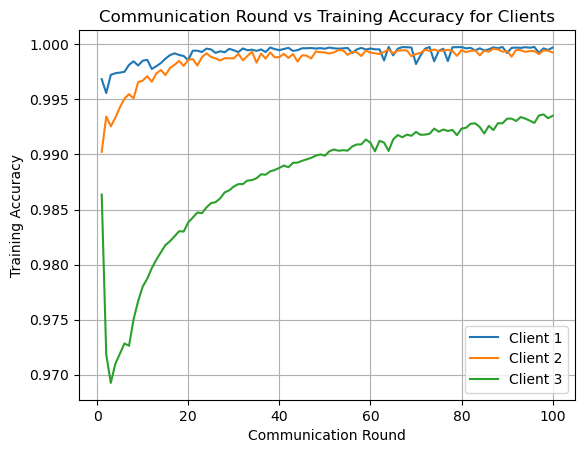

In [ ]:
# Plot the communication round vs training accuracy curve for each client
plt.plot(range(1, communication_rounds ), train_accuracies_client1, label='Client 1')
plt.plot(range(1, communication_rounds ), train_accuracies_client2, label='Client 2')
plt.plot(range(1, communication_rounds ), train_accuracies_client3, label='Client 3')

plt.xlabel('Communication Round')
plt.ylabel('Training Accuracy')
plt.title('Communication Round vs Training Accuracy for Clients')
plt.legend()
plt.grid(True)
plt.show()

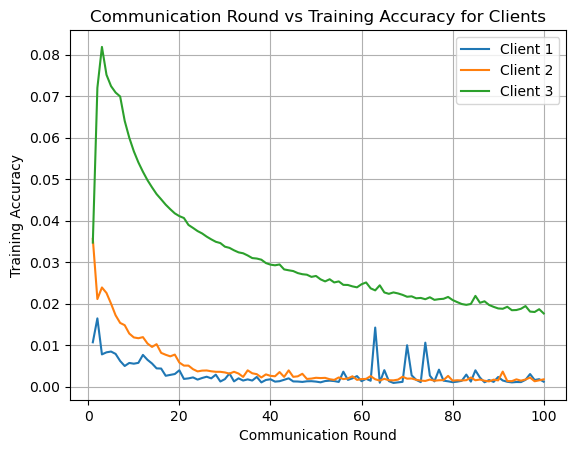

In [ ]:
# Plot the communication round vs training accuracy curve for each client
plt.plot(range(1, communication_rounds ), train_losses_client1, label='Client 1')
plt.plot(range(1, communication_rounds ), train_losses_client2, label='Client 2')
plt.plot(range(1, communication_rounds ), train_losses_client3, label='Client 3')

plt.xlabel('Communication Round')
plt.ylabel('Training Accuracy')
plt.title('Communication Round vs Training Accuracy for Clients')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Predict the test data from each client using the global model
# Predict the test data from each client using the global model
y_pred_client1 =best_local_model_client1.predict(X_val_client1)
y_pred_client2 =best_local_model_client2.predict(X_val_client2)
y_pred_client3 =best_local_model_client3.predict(X_val_client3)
#y_pred_client4 = local_model_client4.predict(X_val_client4)

#y_pred_client1_binary = (y_pred_client1 >= 0.5).astype(int)
#y_pred_client2_binary = (y_pred_client2 >= 0.5).astype(int)
#y_pred_client3_binary = (y_pred_client3 >= 0.5).astype(int)

#y_pred_client1_new=np.argmax(y_pred_client1, axis=1)
#y_pred_client2_new=np.argmax(y_pred_client2, axis=1)
#y_pred_client3_new=np.argmax(y_pred_client3, axis=1)

# Combine the predicted labels and true labels from all clients
#y_true = np.concatenate([y_val_client1, y_val_client2, y_val_client3])

#y_pred = np.concatenate([y_pred_client1_new, y_pred_client2_new, y_pred_client3_new])

# Generate the overall classification report

1059/1059 [==============================] - 2s 2ms/step


In [ ]:
classification_report_global_client1 = classification_report(np.round(y_pred_client1), y_val_client1, digits=6)
print(classification_report_global_client1)
#print(confusion_matrix(np.round(y_pred_client1), y_val_client1))

              precision    recall  f1-score   support

         0.0   0.999472  0.999959  0.999715     49176
         1.0   0.999593  0.994741  0.997161      4944

    accuracy                       0.999483     54120
   macro avg   0.999533  0.997350  0.998438     54120
weighted avg   0.999483  0.999483  0.999482     54120



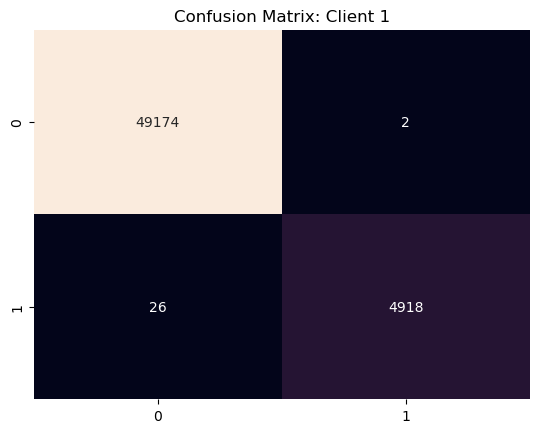

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(np.round(y_pred_client1), y_val_client1)
sns.heatmap(confusion_matrix, annot=True, fmt="d", cbar = False)
plt.title("Confusion Matrix: Client 1")
plt.show()

In [ ]:
classification_report_global_client2 = classification_report(np.round(y_pred_client2), y_val_client2, digits=6)
print(classification_report_global_client2)
#print(confusion_matrix(np.round(y_pred_client2), y_val_client2))

              precision    recall  f1-score   support

         0.0   0.999914  0.994950  0.997426    175854
         1.0   0.949251  0.999098  0.973537     16625

    accuracy                       0.995309    192479
   macro avg   0.974583  0.997024  0.985482    192479
weighted avg   0.995538  0.995309  0.995363    192479



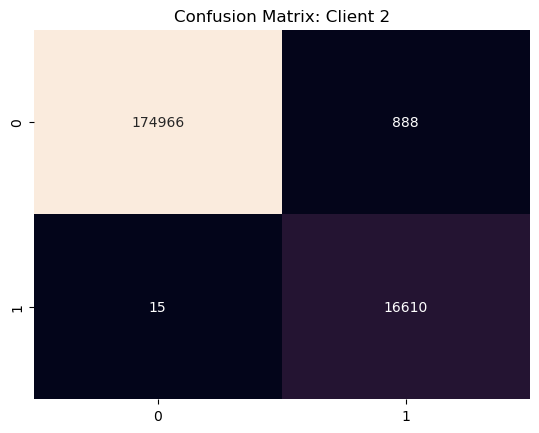

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(np.round(y_pred_client2), y_val_client2)
sns.heatmap(confusion_matrix, annot=True, fmt="d", cbar = False)
plt.title("Confusion Matrix: Client 2")
plt.show()

In [ ]:
classification_report_global_client3 = classification_report(np.round(y_pred_client3), y_val_client3, digits=6)
print(classification_report_global_client3)
#print(confusion_matrix(np.round(y_pred_client3), y_val_client3))

              precision    recall  f1-score   support

         0.0   0.993409  0.996320  0.994863     30710
         1.0   0.963312  0.935962  0.949440      3170

    accuracy                       0.990673     33880
   macro avg   0.978360  0.966141  0.972151     33880
weighted avg   0.990593  0.990673  0.990613     33880



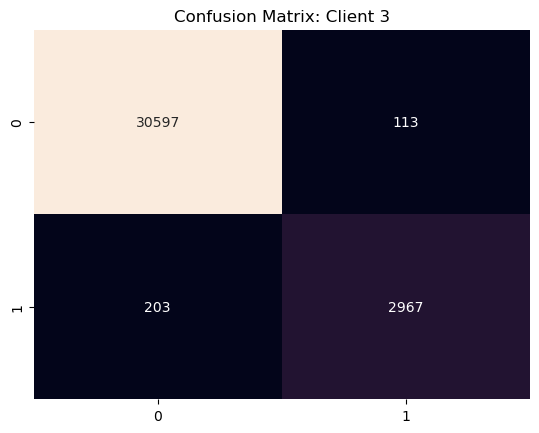

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(np.round(y_pred_client3), y_val_client3)
sns.heatmap(confusion_matrix, annot=True, fmt="d", cbar = False)
plt.title("Confusion Matrix: Client 3")
plt.show()

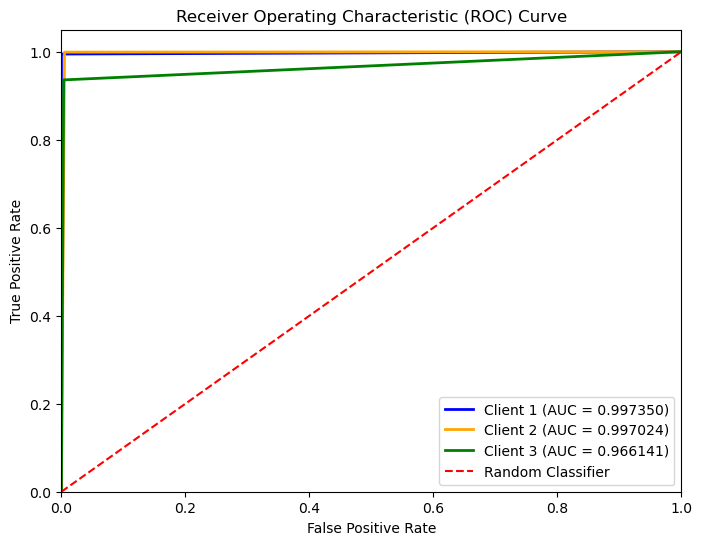

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate TPR, FPR, and thresholds
fpr, tpr, thresholds = roc_curve(np.round(y_pred_client1), y_val_client1)
fpr2, tpr2, thresholds2 = roc_curve(np.round(y_pred_client2), y_val_client2)
fpr3, tpr3, thresholds3 = roc_curve(np.round(y_pred_client3), y_val_client3)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2,linestyle='solid', label='Client 1 (AUC = %0.6f)' % auc(fpr, tpr))
plt.plot(fpr2, tpr2, color='orange', lw=2,linestyle='solid', label='Client 2 (AUC = %0.6f)' % auc(fpr2, tpr2))
plt.plot(fpr3, tpr3, color='green', lw=2,linestyle='solid', label='Client 3 (AUC = %0.6f)' % auc(fpr3, tpr3))
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
